# 1. Facial Expression Classification

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;">Libraries</span></center></h1> 

In [ ]:
!pip install mlxtend --upgrade --no-deps

In [563]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import tensorflow as tf
import cv2
import seaborn as sns

from PIL import Image

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.preprocessing.image as ImageDataGenerator

from google.colab import drive

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Path</span></span></center></h1> 

In [ ]:
#google drive 연동

drive.mount('/content/gdrive/')
path = '/content/gdrive/MyDrive/.kaggle/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# fer2013 데이터 가져오기

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/.kaggle/"

In [ ]:
cd /content/gdrive/My Drive/.kaggle/

/content/gdrive/My Drive/.kaggle


In [ ]:
!kaggle datasets download -d msambare/fer2013

!ls

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
 face_expression_revised   fer2013.zip	 test_image.png     'test_img (3).png'
 face_expression_v0.7	   kaggle.json	'test_img (1).png'   test_img.png
 fer2013.csv		   test		'test_img (2).png'   train


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load Data</span></span></center></h1> 

In [ ]:
data = pd.read_csv(path+'fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


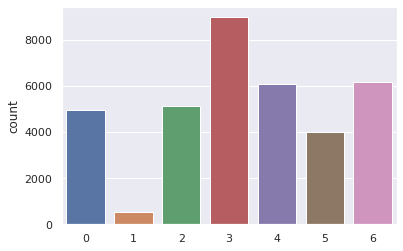

In [578]:
y_train = data['emotion'].values
x_train = data['pixels'].values
usage   = data['Usage']

sns.countplot(y_train)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Functions</span></span></center></h1> 

In [587]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(21, 10))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].grid(False)
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].grid(False)
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    axs[0].grid(False)

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid(True)
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid(True)
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid(True)
    
    plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Overview</span></span></center></h1> 

In [ ]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Prepare Data</span></span></center></h1> 

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [ ]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

Reshape and scale the images:

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Some Examples</span></span></center></h1> 

## All Emotions

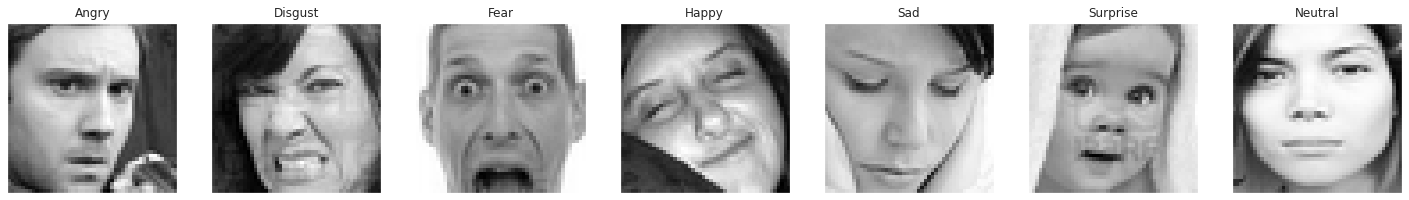

In [586]:
plot_all_emotions()

## Angry

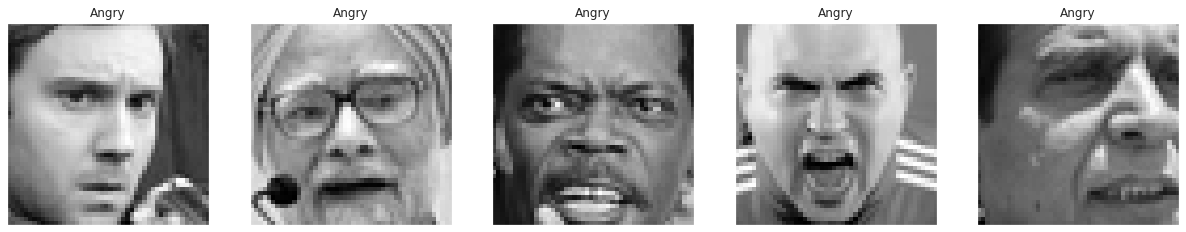

In [588]:
plot_examples(label=0)

## Disgust

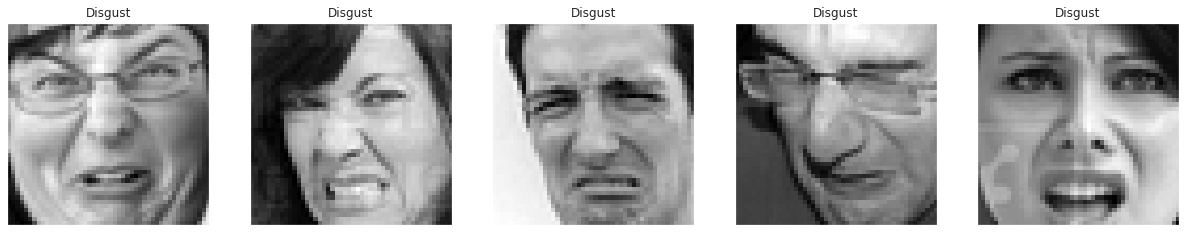

In [589]:
plot_examples(label=1)

## Fear

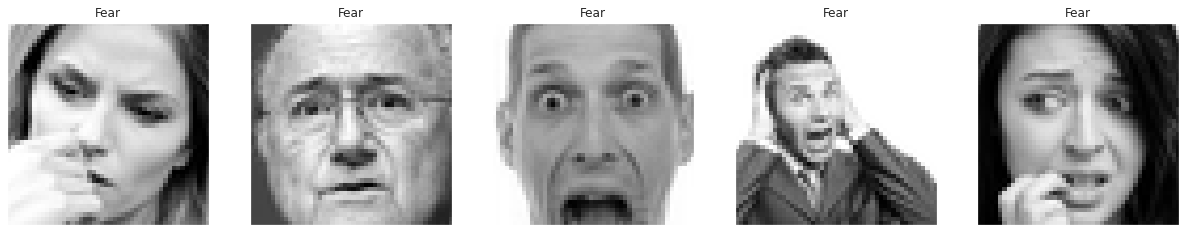

In [590]:
plot_examples(label=2)

## Happy

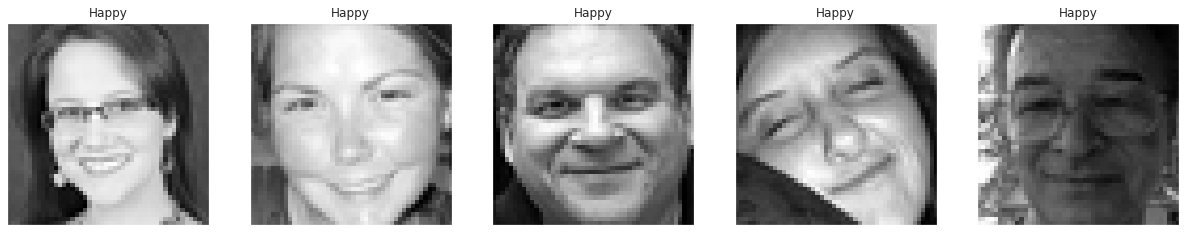

In [591]:
plot_examples(label=3)


## Sad

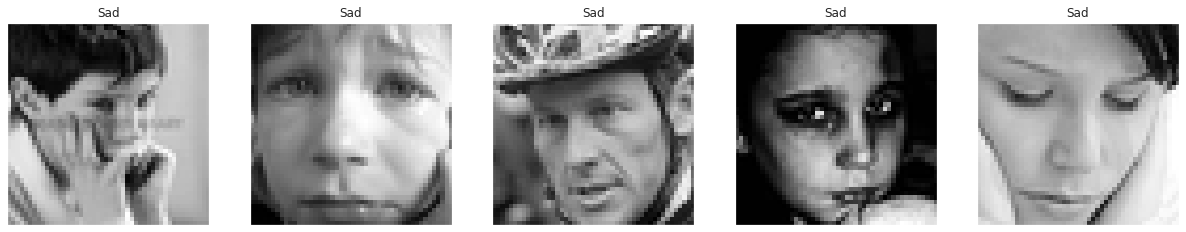

In [592]:
plot_examples(label=4)

## Surprise

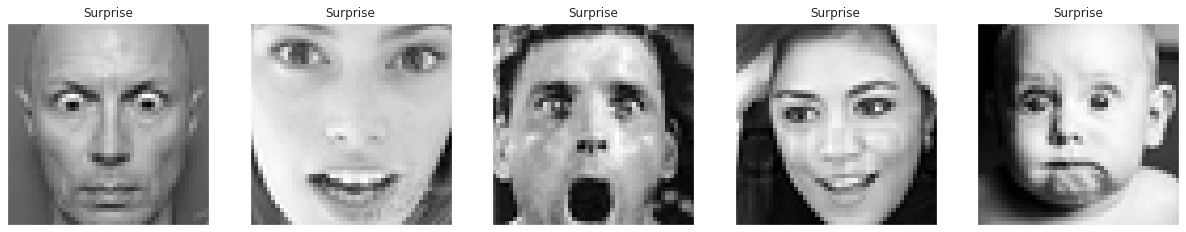

In [593]:
plot_examples(label=5)

## Neutral

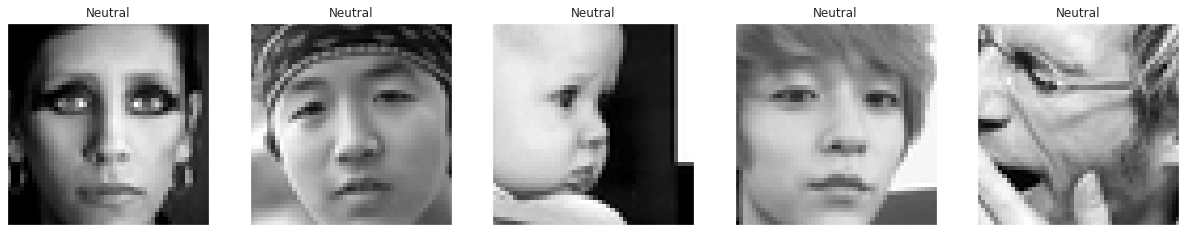

In [594]:
plot_examples(label=6)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Distribution Of Labels</span></span></center></h1> 

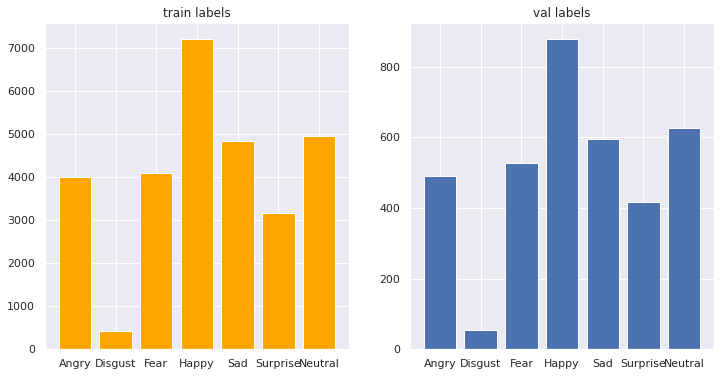

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Class Weights</span></span></center></h1> 
Calculate the class weights of the label distribution:

In [ ]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [ ]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Model</span></span></center></h1> 
We define a simple CNN model:

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [ ]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 74s 160ms/step - loss: 0.2593 - accuracy: 0.3417 - val_loss: 1.5323 - val_accuracy: 0.4263
Epoch 2/12
449/449 [==============================] - 72s 159ms/step - loss: 0.2206 - accuracy: 0.4496 - val_loss: 1.4221 - val_accuracy: 0.4622
Epoch 3/12
449/449 [==============================] - 71s 159ms/step - loss: 0.2015 - accuracy: 0.5005 - val_loss: 1.3590 - val_accuracy: 0.4845
Epoch 4/12
449/449 [==============================] - 72s 160ms/step - loss: 0.1887 - accuracy: 0.5363 - val_loss: 1.3095 - val_accuracy: 0.5141
Epoch 5/12
449/449 [==============================] - 71s 158ms/step - loss: 0.1784 - accuracy: 0.5610 - val_loss: 1.2957 - val_accuracy: 0.5174
Epoch 6/12
449/449 [==============================] - 71s 159ms/step - loss: 0.1684 - accuracy: 0.5859 - val_loss: 1.2323 - val_accuracy: 0.5389
Epoch 7/12
449/449 [==============================] - 72s 160ms/step - loss: 0.1582 - accuracy: 0.6142 - val_loss: 1.2389 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 3s 25ms/step - loss: 1.4439 - accuracy: 0.5536
test accuracy: 0.5536361336708069


In [ ]:
pred_test_labels = model.predict(test_images)

In [ ]:
model.save("/content/gdrive/My Drive/.kaggle/face_expression_revised")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/.kaggle/face_expression_revised/assets


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Convergence</span></span></center></h1> 

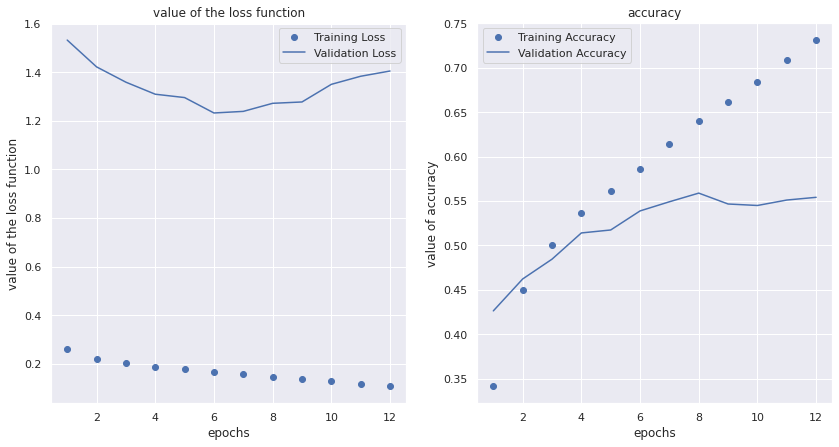

In [433]:
fig=plt.figure(figsize=(14,7))

plt.subplot(1, 2, 1)
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid(True)

plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Results</span></span></center></h1> 

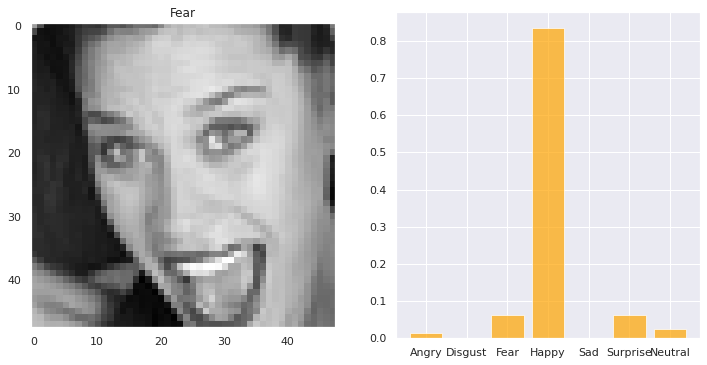

In [584]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 302)

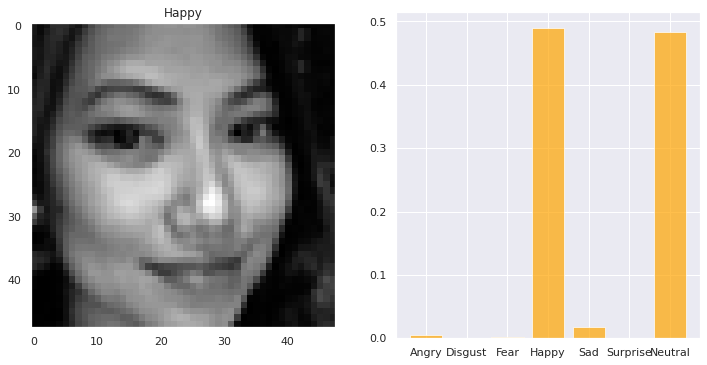

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels,19)

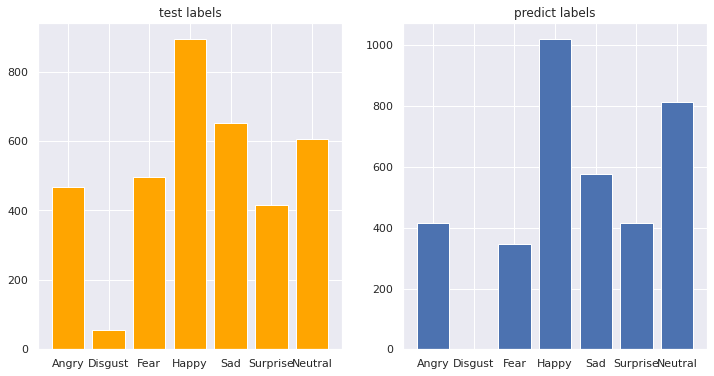

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Wrong Prediction</span></span></center></h1> 

In [ ]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

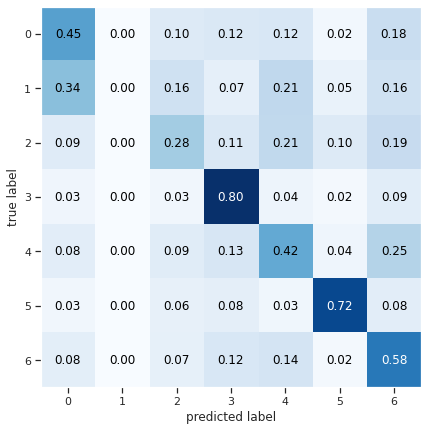

In [538]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                # class_names=emotions.values(),
                                figsize=(7, 7))
fig.show()

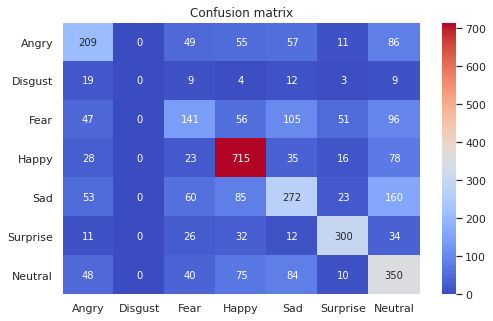

In [621]:
CM = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plt.subplots(figsize=(8,5)) 

ax = sns.heatmap(CM,
                 annot=True,
                 fmt='',
                 annot_kws={"size": 10}, 
                 xticklabels=class_names, 
                 yticklabels=class_names, ax = ax,
                 cmap="coolwarm")

ax.set_title('Confusion matrix')


plt.show()

# 2. Facial Detection

In [411]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/.kaggle/face_expression_revised')
print("[INFO] loading network...")

[INFO] loading network...


In [ ]:
#facial detection pipeline 추가

!pip install mediapipe
print ("Done.")

Done.


In [339]:
from google.colab import files
uploaded = files.upload()

Saving test_image.png to test_image (1).png


test_image.png


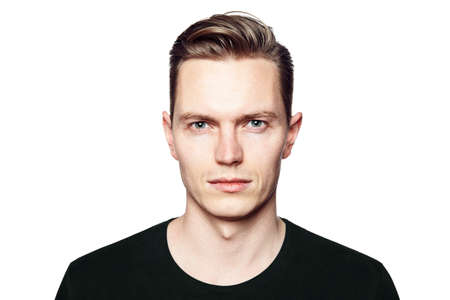

In [341]:
import cv2
from google.colab.patches import cv2_imshow

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  cv2_imshow(image)

In [342]:
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
print ("MediaPipe Face Detection Loaded.")

MediaPipe Face Detection Loaded.


In [343]:
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

Face detections of test_image.png:


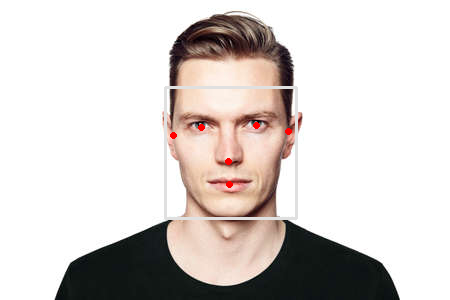

In [514]:
# Run MediaPipe Face Detection.
with mp_face_detection.FaceDetection(
    min_detection_confidence=0.5) as face_detection:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face detections of each face.
    print(f'Face detections of {name}:')
    if not results.detections:
      continue
    annotated_image = image.copy()
    for detection in results.detections:
      mp_drawing.draw_detection(annotated_image, detection)
      cv2_imshow(annotated_image)

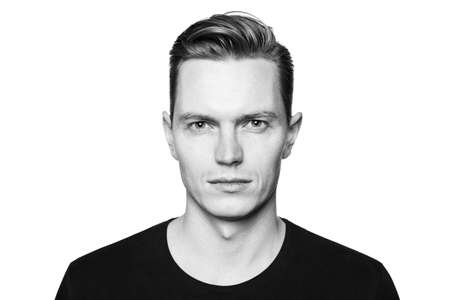

In [515]:
 # Grayscale image
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image_gray)

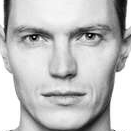

In [516]:
# Crop
xmin = detection.location_data.relative_bounding_box.xmin
ymin = detection.location_data.relative_bounding_box.ymin
width = detection.location_data.relative_bounding_box.width
height = detection.location_data.relative_bounding_box.height
img_height,img_weight = image.shape[0],image.shape[1]
w_fr = np.round(img_weight*xmin).astype(int)
w_to = np.round(img_weight*(xmin+width)).astype(int)
h_fr = np.round(img_height*ymin).astype(int)
h_to = np.round(img_height*(ymin+height)).astype(int)
image_cropped = image_gray[h_fr:h_to,w_fr:w_to]
cv2_imshow(image_cropped)

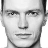

(48, 48)


In [517]:
# Resize
image_resize = cv2.resize(image_cropped,dsize=(48,48))

cv2_imshow(image_resize)
print (image_resize.shape)

In [518]:
from keras.preprocessing.image import img_to_array

In [530]:
input_arr = tf.keras.preprocessing.image.img_to_array(image_resize)
input_arr = np.array([input_arr])
input_arr = input_arr.reshape((input_arr.shape[0], 48, 48, 1))
input_arr = input_arr.astype('float32') / 255

print(input_arr.shape)

(1, 48, 48, 1)


In [531]:
class_names = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

print("[INFO] classifying image...")

prediction = model.predict(input_arr)
pre_ans = prediction.argmax()

for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    
    pre_ans_str = class_names[pre_ans]

print(pre_ans_str)

[INFO] classifying image...
[1.8678920e-02 4.6816145e-05 7.2202680e-04 6.0037895e-05 1.2932840e-02
 7.1655831e-04 9.6684283e-01]
6
Neutral


In [541]:
def plot_image_and_emotion_test(image_cropped, prediction, class_names):
  prediction = model.predict(input_arr)
  pre_ans = prediction.argmax()
  pre_ans_str = class_names[pre_ans]

  fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

  axs[0].imshow(image_cropped, 'gray')
  axs[0].set_title(pre_ans_str)
  axs[0].grid(False)

  axs[1].bar(class_names, prediction[0], color='orange', alpha=0.7)
  axs[1].grid(True)

  plt.show()

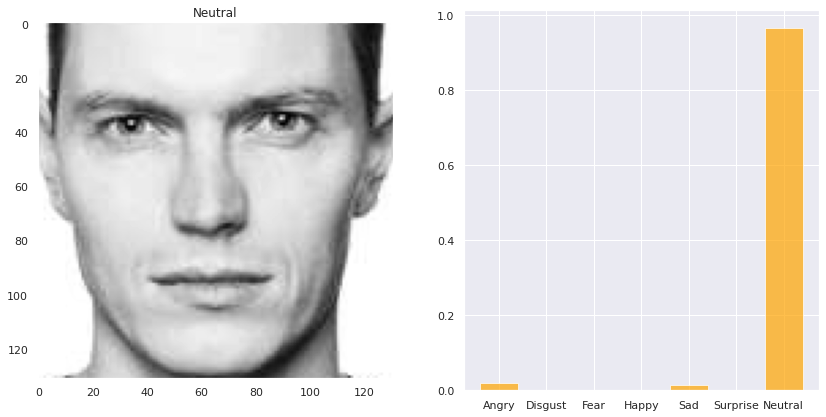

In [542]:
plot_image_and_emotion_test(image_cropped, prediction, class_names)